
# Gutenberg
**Project Gutenberg is a library of over 60,000 free eBooks**

![Gutenberg](https://drive.google.com/uc?export=view&id=1bOd8Hiv-sU8Skj1gYR-2cxLUEBIretyZ)


**Recommended to use GPU to run much faster.
But it works well with the CPU also.**
- GPU takes around 40 mins, while CPU may take hours.

# Project Methodology

![Gutenberg](https://drive.google.com/uc?export=view&id=1wNirZx5kEzvy5tPnS2pCaP2xX0ugpx5N)


# Project Main Steps


- [Data Exploration](#1)
- [Data Preprocessing](#2)
- [Word Embedding](#3)
  - [BOW](#4)
  - [TF-IDF](#5)
  - [Doc2Vec](#6)
  - [Bert Embedding](#7)
  - [Glove](#8)
  - [Fast text](#9)
  - [Word2Vec](#10)
  - [LDA (Linear Discriminant Analysis)](#11)
- [Word embedding dictionary](#12)
- [Clustering](#13)
  - [K-Means](#14)
  - [Expectation Maximization (EM)](#15)
  - [Hierarchical](#16)
- [Choosing Champion Model](#17)
- [Error Analysis](#18)
  - [Cosine Similarity](#19)
  - [Word Count](#20)
- [Conclusion](#21)

**For time-saving we saved our text transformations into a pickle file and there is a section called '[Start here](#start_here)' you can uncomment it and start executing the clustering results**

### Install nltk library and download Gutenberg's digital books

In [ ]:
! pip install nltk
! pip install yellowbrick
! pip install umap-learn
! pip install plotly
! pip install transformers
! pip install pyLDAvis
! pip install pyyaml==5.4.1
seed=42

In [ ]:
import numpy as np
import pandas as pd
import nltk

nltk.download('gutenberg')
books_names=nltk.corpus.gutenberg.fileids()
books_names

# <a id="1">Data Exploration</a>

### Choose 5 books from the different category and different authors

In [ ]:
books_idx=[2,3,13,-6,9]
selected_books=[]
for idx in books_idx :
  selected_books.append(books_names[idx])
print(selected_books)

### Discover these books' content

In [ ]:
book_contents=[]
for book_name in selected_books:
  book_contents.append(nltk.corpus.gutenberg.raw(book_name))
# Display the first 100 character
book_contents[0][1:200]

> - Many problems have been found in books' content, so we should deal with them.

# <a id="2">Data Preprocessing</a>

### Clean the content of the books by:
- Removing the word capitalization,unwanted characters, white spaces, and stop words.
- Replacing some patterns.
- Applying lemmatization and tokenization.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [ ]:
import re
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    lower_book = text.lower()                                              # Converting all words into lower case.
    filtered_book = re.sub(sub_pattern,' ',lower_book).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_book = word_tokenize(filtered_book)                      # tokenizethe whole book into words in a list.
    filtered_book = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_book if word not in stop_words]
    return filtered_book

In [ ]:
cleaned_books_contents=[]
for book in book_contents :
  cleaned_books_contents.append(clean_text(book))
cleaned_books_contents[0][1:100]

### Create 200 random samples from each book, where each sample contains 150 words.

In [ ]:
def book_samples(book,n_samples, n_doc) :
    """This function takes the book text and generate randomly n documents each document has 150 (n_samples) words"""
    import random
    samples=[]
    start=0
    while start + n_samples < len(book)-1:
        temp1=""
        for j in range(start,start+n_samples):
            temp1+= book[j] + " "
        samples.append(temp1)
        start+= n_samples
    random_samples_index=random.sample(range(0,len(samples)),k=min(n_doc,len(samples)))
    partitions=[]
    for idx in random_samples_index :
        partitions.append(samples[idx])
    return partitions

In [ ]:
samples_of_books=[]
for cleaned_book in cleaned_books_contents :
  samples_of_books.append(book_samples(cleaned_book,150,200))
# Display the first document
samples_of_books[0][0]

### Create a data frame containing 2 columns and 1000 rows representing the books' samples (Sample) and the book name (Label).

|id|book sample | book name (label)|
|--|--|--|
||||

In [ ]:
import pandas as pd
data_frame =pd.DataFrame()
data_frame['Sample of the book']=[item for sublist in samples_of_books for item in sublist]
target=[[selected_books[i]]*min(200,len(samples_of_books[i])) for i in range(len(selected_books)) ]
data_frame['Book_name']=[item for sublist in target for item in sublist]
data_frame['Book_name'].unique()

### Shuffling the dataframe with sklearn

In [ ]:
from sklearn.utils import shuffle
data_frame = shuffle(data_frame,random_state=seed)
data_frame

### Apply Label Encoding on the Books' names

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y_actual= label_encoder.fit_transform(data_frame['Book_name'])
data_frame['Book_name']=y_actual

In [ ]:
# you can save the data as a dataset.csv file by run this line
# data_frame.to_csv('dataset.csv')

-----------------------------------

# <a id="3">Word Embedding</a>

It is one of the trivial steps to be followed for a better understanding of the context of what we are dealing with. After the initial text is cleaned and normalized, we need to transform it into its features to be used for modeling.

We used some methods to assign weights to particular words, sentences, or documents within our data before modeling them. We go for numerical representation for individual words as it’s easy for the computer to process numbers.

## <a id="4">BOW</a>

A bag of words is a representation of text that describes the occurrence of words within a document, that just keeps track of word counts and disregards the grammatical details and the word order.
As we said that we split the data. So, we applied BOW to training and testing data.
So, it transforms each sentence into an array of occurrences in this sentence.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
BOW = CountVectorizer()
BOW_transformation = BOW.fit_transform(data_frame['Sample of the book'])

## <a id="5">TF-IDF</a>

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In addition, to understand the relation between each consecutive pair of words, tfidf with bigram has applied.
Furthermore, we applied tfidf with trigram to find out wether there is a relation between each consecutive three words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram,X_train=data_frame['Sample of the book']):
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    return x_train_vec

#### Applying tfidf with 1-gram, 2-gram and 3-gram

In [ ]:
# Applying tfidf with 1-gram, 2-gram and 3-gram
tfidf_1g_transformation= tfidf_ngram(1,X_train=data_frame['Sample of the book'])
tfidf_2g_transformation= tfidf_ngram(2,X_train=data_frame['Sample of the book'])

## <a id="6">Doc2Vec</a>
- Doc2Vec is a method for representing a document as a vector and is built on the word2vec approach.
- I have trained a model from scratch to embed each sentence or paragraph of the data frame as a vector of 50 elements.

In [ ]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
# Tokenization of each document
tokenized_doc = []
for d in data_frame['Sample of the book']:
    tokenized_doc.append(word_tokenize(d.lower()))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[0]

In [ ]:
# Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4, epochs = 100)

In [ ]:
def get_doc2vec_vector(df):
    doc2vec_vectors=[]
    for sentence in data_frame['Sample of the book']:
        doc2vec_vectors.append(model.infer_vector(word_tokenize(sentence.lower())))
    return doc2vec_vectors
doc2vec_vectors=get_doc2vec_vector(data_frame['Sample of the book'])
len(doc2vec_vectors)

## <a id="7">Using BERT as pretrained model</a>

- BERT (Bidirectional Encoder Representations from Transformers) is a highly complex and advanced language model that helps people automate language understanding.
- BERT is the encoder of transformers, and it consists of 12 layers in the base model, and 24 layers for the large model. So, we can take the output of these layers as an embedding vector from the pre-trained model.
- There are three approaches to the embedding vectors: concatenate the last four layers, the sum of the last four layers, or embed the full sentence by taking the mean of the embedding vectors of the tokenized words
- As the first two methods require computational power, we used the third one which takes the mean of columns of each word and each word is represented as a 768x1 vector. so, the whole sentence at the end is represented as a 768x1 vector

In [ ]:
!pip install transformers

In [ ]:
# Check the GPU
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
# Import Libraries
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create sentence and label lists
sentences = data_frame['Sample of the book'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = data_frame.Book_name.values

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
hidden_states=[]
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
# Conver the ids into a tensor representation
batch_size = 4
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)
# Initialize the model
if torch.cuda.is_available():
    model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cuda')
else:
    model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cpu')
model.eval()
outputs = []

In [ ]:
for input, masks in dataloader:
    torch.cuda.empty_cache() # empty the gpu memory
    # Transfer the batch to gp
    if torch.cuda.is_available():
        input = input.to('cuda')
        masks = masks.to('cuda')
    # Run inference on the batch
    output = model(input, attention_mask=masks)
    # Transfer the output to CPU again and convert to numpy
    output = output[0].cpu().detach().numpy()
    # Store the output in a list
    outputs.append(output)
# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

**Embed the full sectence by taking the mean of the embedding vectors of the tokenized words**

In [ ]:
bert_vectors=np.array(outputs)
bert_vectors=bert_vectors.mean(axis=1)
bert_vectors.shape

## Helper function

In [ ]:
import gensim.downloader as api
def get_vectors_pretrained(df, model):
    embedding_vectors = []
    for partition in df['Sample of the book']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass
        sentence = np.array(sentence)
        sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

## <a id="8">Glove</a>
- Global vector for word representation is an unsupervised learning algorithm for word embedding.
- We trained a GloVe model on books’ data, that represents each word in a 300x1 Vector. We took the data frame after cleaning and get each paragraph and passed it to the corpus. After that,t we trained the model on each word.
- We used also a pre-trained model “glove-wiki-gigaword-300”. Each word is represented by a 300x1 vector. Then, on each word of a sentence in the data frame, we replaced it with its vector representation.

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")  # load glove vectors
glove_vectors=get_vectors_pretrained(data_frame,glove_model)
glove_vectors

## <a id="9">Fast text</a>
- FastText is a library for learning word embeddings and text classification. The model allows one to create unsupervised learning or supervised learning algorithms for obtaining vector representations for words.
- We loaded a pre-trained model from genism API ‘fasttext-wiki-news-subwords-300’.

In [ ]:
import gensim.downloader as api
fast_text_model = api.load("fasttext-wiki-news-subwords-300")  # load glove vectors
fast_text_vectors=get_vectors_pretrained(data_frame,fast_text_model)
fast_text_vectors

## <a id="10">Word2Vec</a>
- Word2vec is a method to represent each word as a vector.
- We used a pre-trained model “word2vec-google-news-300”.

In [ ]:
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")  # load glove vectors
word2vec_vectors = get_vectors_pretrained(data_frame,word2vec_model)
word2vec_vectors

## <a id="11">LDA (Latent Dirichlet Allocation)</a>
- It is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. LDA is an example of a topic model.
- We used LDA as a transformer after vectorization used in BOW because LDA can’t vectorize words. So, we needed to use it after BOW.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim

paragraphs = data_frame["Sample of the book"].to_list()
docs = []

for sen in paragraphs:
    docs.append(list(sen.split()))
print(len(docs))

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.8)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(len(corpus[2]))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))


In [ ]:
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
#print(len(dictionary))
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [ ]:
all_topics = model.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
lda_to_cluster = all_topics_csr.T.toarray()
lda_to_cluster.shape

In [ ]:
# !pip install pyLDAvis

#### Measure the coherence per topic of the LDA model

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
## Evaluating coherence of gensim LDA model
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence_score = cm.get_coherence()
print(coherence_score)

# <a id="12">Word embedding dictionary</a>

In [ ]:
text_embedding={
    'BOW':BOW_transformation.toarray(),
    'TF_IDF 1_gram':tfidf_1g_transformation.toarray(),
    'Doc2vec':np.array(doc2vec_vectors),
    'Glove':glove_vectors,
    'FastText':fast_text_vectors,
    'Word2vec':word2vec_vectors,
    'BERT':bert_vectors,
    'LDA':lda_to_cluster,
}

### Save word Embedding as a pickle file 
For future use, the embedding takes a long time. So, if you want to start directly with the embedded data that has been computed previously.

In [ ]:
import pickle
a_file = open("EmbeddingText_edited.pkl", "wb")
pickle.dump(text_embedding, a_file)
a_file.close()
print('Saved')

# <a id='start_here'>Start here</a>

In [ ]:
!gdown --id 1ajm_Az1wn16aI9b8kD1ao3efRiB1KJCz
!gdown --id 1XBbRmnhaI17OLh2FqhUdQdn2rq2KJJIq

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ajm_Az1wn16aI9b8kD1ao3efRiB1KJCz
To: /content/dataset.csv
100% 978k/978k [00:00<00:00, 102MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XBbRmnhaI17OLh2FqhUdQdn2rq2KJJIq
To: /content/EmbeddingText_edited.pkl
100% 232M/232M [00:01<00:00, 177MB/s]


In [ ]:
import pickle
import pandas as pd
import numpy as np
with open('EmbeddingText_edited.pkl', 'rb') as f:
    text_embedding = pickle.load(f)
y_actual=list(pd.read_csv('dataset.csv')['Book_name'])

In [ ]:
data_frame = pd.read_csv('dataset.csv').drop('Unnamed: 0', axis=1)

# <a id="22">Word embedding visualization</a>

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
pca=PCA(n_components=2,)
embedding=text_embedding.copy()

for key in embedding.keys():
  embedding[key]=pca.fit_transform(embedding[key])
  df=pd.DataFrame({'PCA1':embedding[key][:,0],'PCA2':embedding[key][:,1],'Target':y_actual})
  fig = px.scatter(data_frame =df, x='PCA1', y='PCA2', color='Target')
  fig.update_layout(title={'text':f'{key}','x':0.5},height=500,width=700)
  fig.show()

> - The Doc2Vec seems the most separable one.

# Mapping function

In [ ]:
def label_mapping(num, y_actual, y_target, df_labels):
    if num == df_labels[df_labels[y_actual]==0][y_target].value_counts().idxmax():
        return 0
    if num == df_labels[df_labels[y_actual]==1][y_target].value_counts().idxmax():
        return 1
    if num == df_labels[df_labels[y_actual]==2][y_target].value_counts().idxmax():
        return 2
    if num == df_labels[df_labels[y_actual]==3][y_target].value_counts().idxmax():
        return 3
    if num ==df_labels[df_labels[y_actual]==4][y_target].value_counts().idxmax():
        return 4
    else :
      return num

In [ ]:
def lab(df):
    for i in range(5):
      cluster_idx=df[df['y_pred']==i].index.to_list()
      if len(cluster_idx)>0:
        right_cluster=df.loc[cluster_idx,'y_actual'].mode()[0]
        df['y_pred']=df['y_pred'].apply(lambda x: right_cluster+1000 if x==i else x)
    return df

# <a id="13">Clustering</a>

Training Models:
- Kmeans is an unsupervised machine learning algorithm in which each observation belongs to the cluster with the nearest mean.
- Expectation Maximization (EM) clustering is to estimate the means and standard deviations for each cluster to maximize the likelihood of the observed data.
- Hierarchical clustering is an algorithm that groups similar objects into groups. The endpoint is a set of clusters, where each cluster is distinct from the other cluster, and the objects within each cluster are broadly like each other.
- As we have 8 embedding methods and 3 clustering models. So, we have 24 models for all our transformation methods.

## <a id="14">K-Means</a>

K-means is an unsupervised machine learning algorithm in which each observation belongs to the cluster with the nearest mean.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
from sklearn.metrics import cohen_kappa_score
warnings.filterwarnings('ignore')

In [ ]:
text_embedding.keys()

dict_keys(['BOW', 'TF_IDF 1_gram', 'Doc2vec', 'Glove', 'FastText', 'Word2vec', 'BERT', 'LDA'])

In [ ]:
# function to apply k-means by passing the maximum number of clusters and the data
# Retrieving two dictionaries; first one has each K-value with its wcss and the latter has each K-value with its silhouette score
def run_KMeans(max_k, data):
    max_k+=1
    kmeans_elb_results = dict()
    kmeans_sil_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , max_iter=300
                               , random_state = seed
                               , algorithm = 'full')
        kmeans.fit(data)
        kmeans_elb_results.update( {k : kmeans.inertia_} )
        kmeans_sil_results.update({k:silhouette_score(data, kmeans.labels_)})
        
    return  kmeans_elb_results, kmeans_sil_results

In [ ]:
# Creating dictionary of each k-values for each vectorizer
seed = 42
kmeans_elb_vec = dict()
kmeans_sil_vec = dict()
for k,v in text_embedding.items():
    kmeans_elb_results, kmeans_sil_results = run_KMeans(10, v)
    kmeans_elb_vec[k] = kmeans_elb_results
    kmeans_sil_vec[k] = kmeans_sil_results

### Use the Elbow Method to get the best number of clusters.

In [ ]:
fig = make_subplots(rows=3, cols=3,horizontal_spacing=0.1,vertical_spacing=0.1);
i=j=1
for elb_vec_key, elb_vec_value in kmeans_elb_vec.items():
        fig.add_trace( 
            go.Scatter(
                x=list(elb_vec_value.keys()),
                y=list(elb_vec_value.values()),
                mode='lines',
                name=elb_vec_key,
                      ),row=i, col=j)
        j+=1
        if j == 4:
            j=1
            i+=1
fig.update_layout(height=1000, width=1000,title={'text':'K Means for each vectorizer using Elbow Method','x':0.5})
fig.show()

> - The elbow graphs vote for 5 clusters

### Use the Silhouette Method to get the best number of clusters.

In [ ]:
fig = make_subplots(rows=3, cols=3,horizontal_spacing=0.1,vertical_spacing=0.1);
i=j=1
for sil_vec_key, sil_vec_value in kmeans_sil_vec.items():
        fig.add_trace( 
            go.Scatter(
                x=list(sil_vec_value.keys()),
                y=list(sil_vec_value.values()),
                mode='lines',
                name=sil_vec_key,
                      ),row=i, col=j)
        j+=1
        if j == 4:
            j=1
            i+=1
fig.update_layout(height=1000, width=1000,title={'text':'K Means for each vectorizer using Silhouette Method','x':0.5})
fig.show()

> - **As shown in the above graphs that TFIDF, Glove, Bert, Doc2Vec, and LDA vectorizers divide these books into 5 clusters, besides LDA vectorizer has the highest silhouette score.**

### Choose the best Word embedding technique based on the highest Cohen's Kappa score at k =5

In [ ]:
vecs = list(text_embedding.keys())
vec_kappa = dict()
for vec in vecs:
  kmeans_doc2vec = KMeans(n_clusters = 5
                               , init = 'k-means++'
                               , n_init = 10
                               , max_iter=300
                               , random_state = seed
                               , algorithm = 'full')
  kmeans_doc2vec.fit(text_embedding[vec])
  y_pridect = kmeans_doc2vec.predict(text_embedding[vec]) 
  y_df = pd.DataFrame({'y_actual':y_actual, 'y_pred':y_pridect})
  y_df['y_pred'] = y_df['y_pred'].apply(lambda val: label_mapping(num=val, y_actual ='y_actual', y_target='y_pred', df_labels=y_df))
  # y_df['y_pred']=y_df['y_pred'].apply(lambda x : x-1000 if x > 20 else x)
  # y_df=lab(y_df)
  kappa_score = cohen_kappa_score(y_df['y_actual'], y_df['y_pred'])
  vec_kappa[vec] = kappa_score
vec_kappa

{'BOW': 0.6212500000000001,
 'TF_IDF 1_gram': 0.9625,
 'Doc2vec': 0.9925,
 'Glove': 0.7262500000000001,
 'FastText': 0.78,
 'Word2vec': 0.78375,
 'BERT': 0.39875000000000005,
 'LDA': -0.006250000000000089}

In [ ]:
fig = go.Figure()
obj = go.Bar(x = list(vec_kappa.keys()), y = list(vec_kappa.values()))
fig.add_trace(obj)
fig.update_layout(title={'text':'Kappa Score for Different Vectorizers','x':0.5},height=600,width=600)
fig.show()

> - **As shown in the above graph, KThe Highest Kappa score is Doc2Vec with 99.25%.**

### Clusters Visualization

#### Apply PCA

In [ ]:
from sklearn.decomposition import PCA

def apply_PCA(data):
    pca = PCA(n_components=2) 
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    return principalDf
pca_df = apply_PCA(text_embedding['Doc2vec'])
pca_df_final = pd.concat([pca_df, pd.Series(y_actual,name='target')],axis=1)
pca_df_final

,principal component 1,principal component 2,target
0,2.611112,1.886881,4
1,1.141306,6.027030,3
2,-3.776240,4.335576,3
3,-0.922906,4.543417,3
4,4.220962,-2.318588,4
...,...,...,...
995,-4.015244,-4.480462,0
996,6.543847,-3.707579,1
997,-3.998150,0.480520,2
998,5.680234,-1.262139,4


#### Apply K-Means on the PCA transformed data

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter=300, random_state = seed, algorithm = 'full')
kmeans.fit(pca_df)
kmeans_labels = kmeans.predict(pca_df)
kmeans_df_final = pd.concat([pca_df, pd.Series(kmeans_labels,name='target')],axis=1)
centroids = kmeans.cluster_centers_
kmeans_df_final

,principal component 1,principal component 2,target
0,2.611112,1.886881,0
1,1.141306,6.027030,3
2,-3.776240,4.335576,3
3,-0.922906,4.543417,3
4,4.220962,-2.318588,4
...,...,...,...
995,-4.015244,-4.480462,2
996,6.543847,-3.707579,4
997,-3.998150,0.480520,1
998,5.680234,-1.262139,4


#### Map the predicted clusters to the proper Labels

In [ ]:
df_labels1 = pd.DataFrame({'Labels':pca_df_final['target'], 'Predicted Labels': list(kmeans_df_final['target']) })
df_labels1['Predicted Labels'] = df_labels1['Predicted Labels'].apply(lambda val: label_mapping(num=val, y_actual ='Labels', y_target='Predicted Labels', df_labels=df_labels1))
kmeans_df_final['target'] = df_labels1['Predicted Labels']

In [ ]:
from plotly.subplots import make_subplots
fig1 = px.scatter(data_frame =pca_df_final, x='principal component 1', y='principal component 2', color='target')
fig1.update_layout({'title':{'text': 'The Clusters with Actual Labels','x':0.5}},height=600,width=600)
fig1.show()
fig2 = px.scatter(data_frame =kmeans_df_final, x='principal component 1', y='principal component 2', color='target')
fig2.update_layout(annotations=[
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[0][0],
            y=centroids[0][1],
            text="X"),
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[1][0],
            y=centroids[1][1],
            text="X",
),
        dict(font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[2][0],
            y=centroids[2][1],
            text="X",
        ),
dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[3][0],
            y=centroids[3][1],
            text="X",
        ),dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[4][0],
            y=centroids[4][1],
            text="X",
        )],height=600,width=600)
fig2.update_layout({'title':{'text': 'The Clusters with K-means','x':0.5},},height=600,width=600)
fig2.show()

## <a id="15">Expectation Maximization (EM)</a>

EM clustering is to estimate the means and standard deviations for each cluster to maximize the likelihood of the observed data.

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
y_df = pd.DataFrame({'y_actual':y_actual,'y_pred':y_actual})

#### **Important Note:** for BOW and TF_IDF we should perform PCA to decrease number of features

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1000,)
text_embedding_pca=text_embedding.copy()
text_embedding_pca['BOW']=pca.fit_transform(text_embedding['BOW'])
text_embedding_pca['TF_IDF 1_gram']=pca.fit_transform(text_embedding['TF_IDF 1_gram'])

#### Use the Silhouette Method to get the best number of clusters.

In [ ]:
from sklearn.metrics import silhouette_score,cohen_kappa_score
n_clusters = np.arange(2,10)

silhouette_for_each_transformation=text_embedding_pca.copy()
for key in silhouette_for_each_transformation.keys():
    silhouette_for_each_transformation[key]=[]

bic_for_each_transformation=text_embedding_pca.copy()
for key in bic_for_each_transformation.keys():
    bic_for_each_transformation[key]=[]


labels_for_each_transformation=text_embedding_pca.copy()
for key in labels_for_each_transformation.keys():
    labels_for_each_transformation[key]=[]

kappa_for_each_transformation=text_embedding_pca.copy()

y_df = pd.DataFrame({'y_actual':y_actual,'y_pred':y_actual})
for key in text_embedding_pca.keys():
    silhouette_scores=[]
    bic=[]
    aic=[]
    kappa_at_5=[]
    labels_list=[]
    for n in n_clusters :
        model=GaussianMixture(n, covariance_type='full', random_state=seed)
        labels=model.fit_predict(text_embedding_pca[key])
        silhouette_scores.append(silhouette_score(text_embedding_pca[key],labels=labels))
        if n==5 :
          y_df['y_pred']=labels
          y_df['y_pred']=y_df['y_pred'].apply(lambda row: label_mapping(num=row,y_actual = 'y_actual',y_target='y_pred',df_labels=y_df ))
          y_df['y_pred']=y_df['y_pred'].apply(lambda x: x-1000 if x>20 else x)
          right_labels_mapping=y_df['y_pred']
          kappa_at_5=cohen_kappa_score(y_actual,right_labels_mapping )
        bic.append(model.bic(text_embedding_pca[key]))
        labels_list.append(labels)
    silhouette_for_each_transformation[key].append(silhouette_scores)
    bic_for_each_transformation[key].append(bic)
    kappa_for_each_transformation[key]=kappa_at_5
    labels_for_each_transformation[key].append(labels_list)

In [ ]:
idx=[(1,1),(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)]
fig = make_subplots(rows=3, cols=3,horizontal_spacing=0.1,vertical_spacing=0.1);
count=0
for key in silhouette_for_each_transformation.keys() :
    silhouette_scores=list(silhouette_for_each_transformation[key][0])
    fig.add_trace(
            go.Scatter(
                x=list(n_clusters),
                y=list(silhouette_scores),
                mode='lines',
                name=key,
                      ),row=idx[count][0], col=idx[count][1])
    count+=1
fig.update_layout(height=1000, width=1000,title={'text':'Trying different K values to each transformation method and check the Silhouette score','x':0.5})
fig.show()

> - The highest silouette score when using LDA transformation with k =4

### Check kappa scores when k =5 with all transformations

In [ ]:
kappa_for_each_transformation

{'BOW': 0.38625,
 'TF_IDF 1_gram': 0.9575,
 'Doc2vec': 0.99625,
 'Glove': 0.7262500000000001,
 'FastText': 0.79625,
 'Word2vec': 0.635,
 'BERT': 0.41625,
 'LDA': -0.023749999999999938}

In [ ]:
fig = go.Figure()
obj = go.Bar(x = list(kappa_for_each_transformation.keys()), y = list(kappa_for_each_transformation.values()))
fig.add_trace(obj)
fig.update_layout(title={'text':'Kappa Score for Different Vectorizers','x':0.5},height=600,width=600)
fig.show()

> - According to kappa scores, The highest Kappa score is Doc2vec with 99.6%.

### Using PCA with the highest silhouette score to visualize clusters

#### **Doc2Vec (Highest Kappa Score):**

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2,)
embedding=text_embedding.copy()
key='Doc2vec'
embedding[key]=pca.fit_transform(embedding[key])
df=pd.DataFrame({'PCA1':embedding[key][:,0],'PCA2':embedding[key][:,1],'Target':labels_for_each_transformation[key][0][3]})
fig = px.scatter(data_frame =df, x='PCA1', y='PCA2', color='Target')
fig.update_layout(title={'text':f'{key}','x':0.5},height=500,width=500)
fig.show()

#### LDA (Highest Silhouette Score):

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2,)
embedding=text_embedding.copy()
key='LDA'
embedding[key]=pca.fit_transform(embedding[key])
df=pd.DataFrame({'PCA1':embedding[key][:,0],'PCA2':embedding[key][:,1],'Target':labels_for_each_transformation[key][0][3]})
fig = px.scatter(data_frame =df, x='PCA1', y='PCA2', color='Target')
fig.update_layout(title={'text':f'{key}','x':0.5},height=500,width=500)
fig.show()

> - According to the human metric, we have 5 books means 5 clusters, so the best model is Doc2vec with k=5.

## <a id="16">Hierarchical</a>

Hierarchical clustering is an algorithm that groups similar objects into groups. The endpoint is a set of clusters, where each cluster is distinct from the other cluster, and the objects within each cluster are broadly like each other.

In [ ]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from yellowbrick.text import TSNEVisualizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def plot_cluster(model,X):
    yhat = model.fit_predict(X)
    clusters = unique(yhat)

    tsne = TSNEVisualizer(random_state=seed)
    tsne.fit(X, yhat)
    tsne.show()

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering

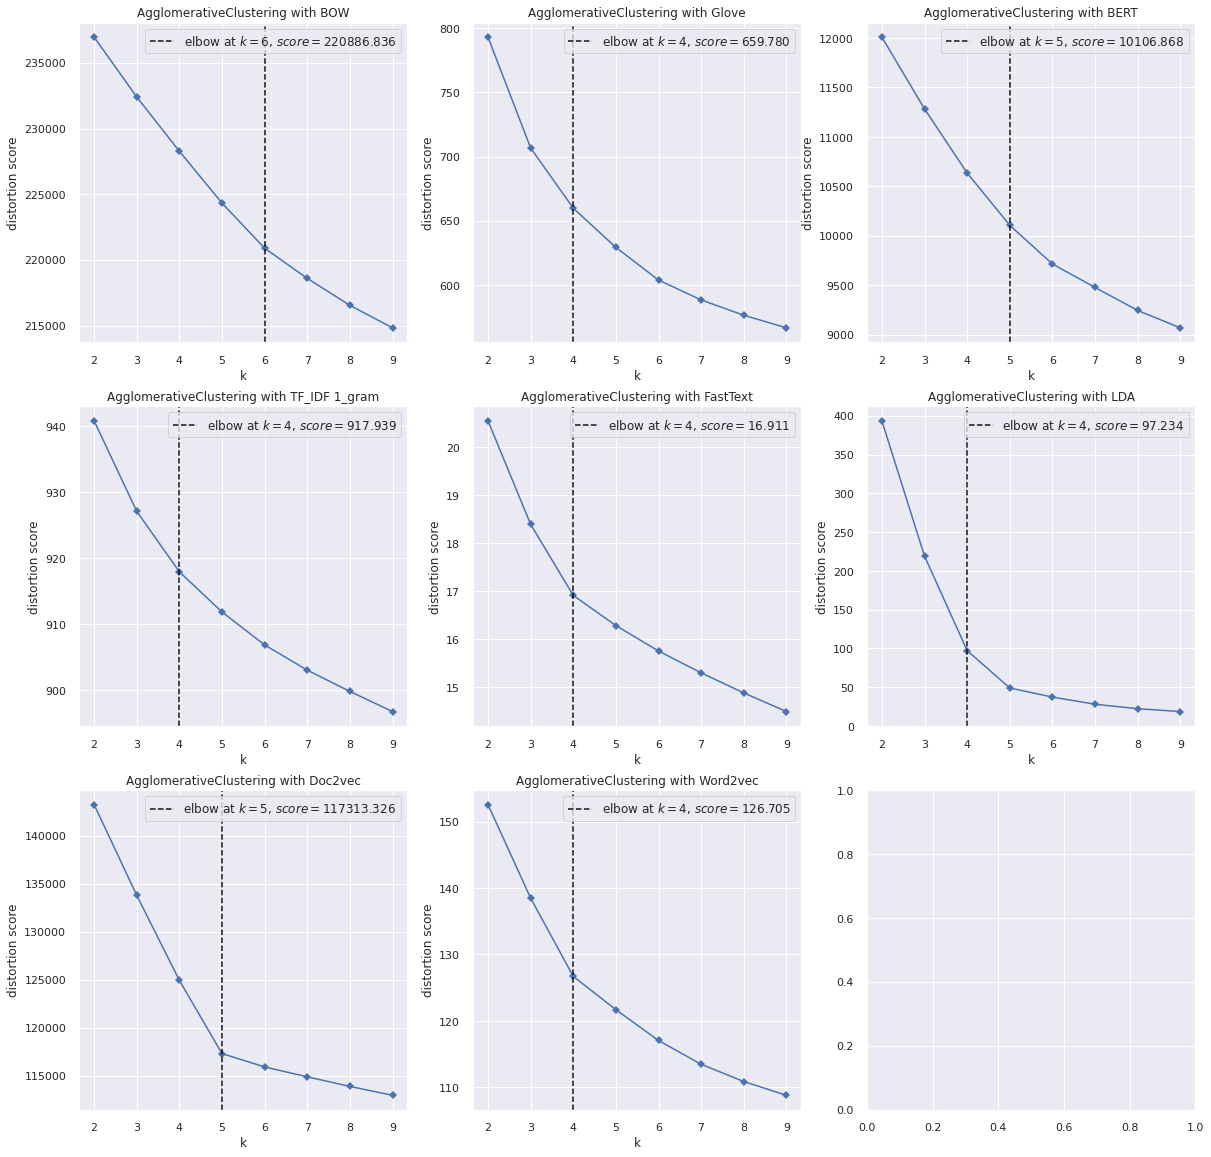

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
# from yellowbrick.features import FeatureImportances
# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# from sklearn.linear_model import LogisticRegression

x_size , y_size =3,3
fig, axes = plt.subplots(3, 3,figsize=(20,20))

model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i%x_size][i//y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

> - Majority of the models voted for k =4.

### Use the silhouette Method to get the best number of clusters.

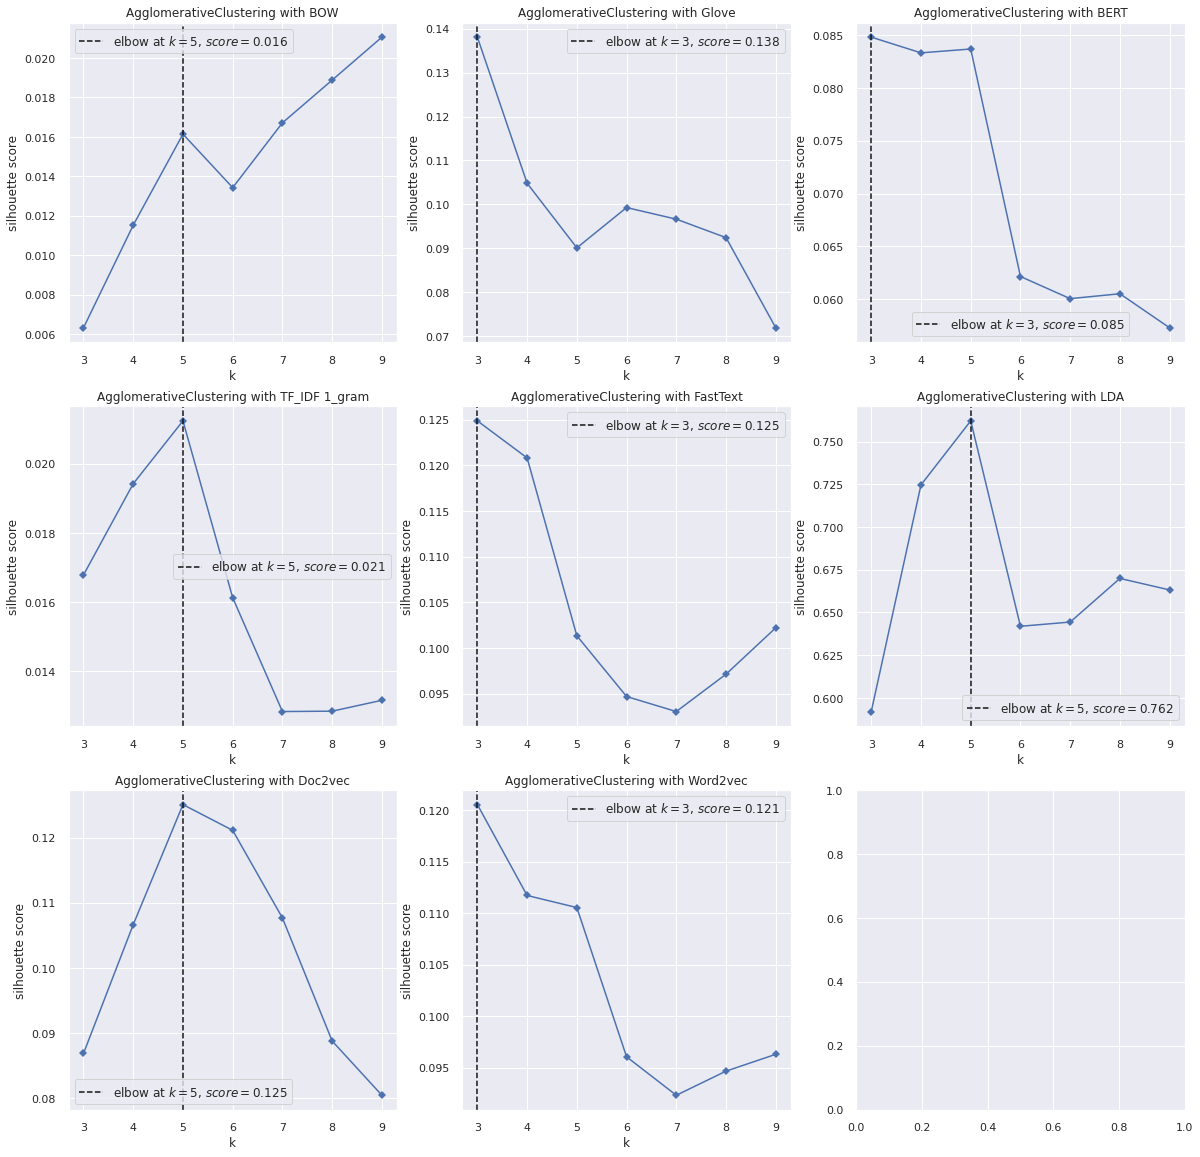

In [ ]:
import matplotlib.pyplot as plt

x_size , y_size =3,3
fig, axes = plt.subplots(3, 3,figsize=(20,20))
model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i%x_size][i//y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(3,10), metric='silhouette', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

> - Majority of the models voted for k =5.

**The silhouette score oreders:**
- LDA has .762 score at 5
- Glove has .128 score at 3
- Doc2vec has .126 score at 5

### Use the Kappa score to get the best embedding vector technique.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

models = [AgglomerativeClustering(n_clusters=5),
          # Birch(n_clusters=5),
          # MiniBatchKMeans(n_clusters=5),
          # KMeans(n_clusters=5),
          # SpectralClustering(n_clusters=5)
]

models_scores = {}
for model in models:
  print(type(model).__name__)
  kappa_scores = {}
  for key in text_embedding.keys():
    clustering = model.fit(text_embedding[key])
    df_labels = pd.DataFrame({'y_actual':y_df['y_actual'], 'y_pred':clustering.labels_})
    df_labels['y_pred'] = df_labels['y_pred'].apply(lambda val: label_mapping(num=val,y_actual = 'y_actual',y_target='y_pred',df_labels=df_labels ))
    df_labels['y_pred']=df_labels['y_pred'].apply(lambda x: x-1000 if x>20 else x)
    kappa_score = cohen_kappa_score(df_labels['y_actual'], df_labels['y_pred'])
    kappa_scores[key] = kappa_score
    print(key, ':', kappa_score)
  models_scores[type(model).__name__] = kappa_scores

AgglomerativeClustering
BOW : 0.38125
TF_IDF 1_gram : 0.97625
Doc2vec : 0.9925
Glove : 0.7887500000000001
FastText : 0.88625
Word2vec : 0.59375
BERT : 0.37875000000000003
LDA : 0.0012499999999999734


In [ ]:
for model_scores,model in zip(models_scores.keys(),models):
    fig = go.Figure()
    obj = go.Bar(x = list(models_scores[model_scores].keys()), y = list(models_scores[model_scores].values()))
    fig.add_trace(obj)
    fig.update_layout(title={'text':f'Kappa Score of the {type(model).__name__}','x':0.5},height=600,width=800)
    fig.show()

> - The highest Kappa score at Doc2Vev With 99.25%.

### Plot the dendrogram for the hierarchical model

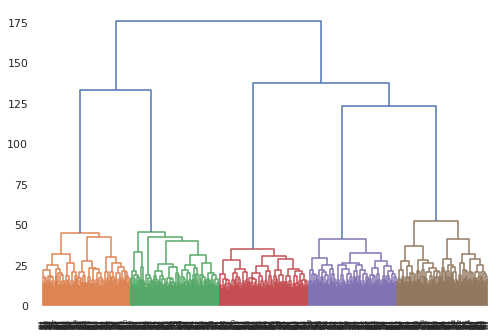

In [ ]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dendrogram = sch.dendrogram(sch.linkage(text_embedding['Doc2vec'], method='ward'))
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(text_embedding['Doc2vec'])

# <a id="17">Choosing Champion Model</a>

**Compare all models with Kappa scores to find the champion model**

### Plot the models kappa scores

- As Doc2Vec achieved the best scores in all the models. we applied the three models with doc2vec to choose the champion model

In [ ]:
Highest_kappa_models = {'Kmeans':vec_kappa['Doc2vec'],'EM':kappa_for_each_transformation['Doc2vec'],'Agglomerative':models_scores['AgglomerativeClustering']['Doc2vec']}

fig = go.Figure()
obj = go.Bar(x = list(Highest_kappa_models.keys()), y = list(Highest_kappa_models.values()))
fig.add_trace(obj)
fig.update_layout(title={'text':f'The champion models','x':0.5},yaxis_range=[.9,1],height=600,width=800)
fig.show()

> - As shown in the figure, Doc2Vec with the Expected Maximization (EM) cluster has the best score among all clusters.

# <a id="18">Error Analysis</a>

Analyzed the error using 2 methods: 
- Cosine similarity 
- Word count

## <a id="19">Cosine Similarity</a>

- Calculated the mean of the actual and predicted books as a vector of 50x1
- Calculated cosine similarity between the correct book and the wrong classified sample.
- Calculated cosine similarity between the wrong book and the wrong classified sample.
- Compare the similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
k=5
embedding=text_embedding['Doc2vec']
model =GaussianMixture(n_components=k,random_state=seed)

y_pred =model.fit_predict(embedding)
#mapping
mapping_df=pd.DataFrame({'y_actual':y_actual,'y_pred':y_pred})
mapping_df['y_pred']=mapping_df['y_pred'].apply(lambda x: label_mapping(x, 'y_actual', 'y_pred', mapping_df))
mapping_df['y_pred']=mapping_df['y_pred'].apply(lambda x: x-1000 if x >20 else x )
# mapping_df=lab(mapping_df)
wrong_examples_pred_actual=mapping_df[mapping_df['y_actual']!=mapping_df['y_pred']]
wrong_idx=mapping_df[mapping_df['y_actual']!=mapping_df['y_pred']].index.tolist()
# print(wrong_idx)
wrong_examples_pred_actual['samples']=list(embedding[wrong_idx,:])

books=pd.DataFrame()
books['labels']=y_actual
books['samples']=list(embedding)
book_means=books.groupby('labels').mean()
wrong_smi=[]
correct_smi=[]
for i in range(len(wrong_examples_pred_actual)):
    true_book=book_means.loc[wrong_examples_pred_actual.iloc[i][0]][:][0].reshape(1,-1)
    wrong_book=book_means.loc[wrong_examples_pred_actual.iloc[i][1]][:][0].reshape(1,-1)
    sample=wrong_examples_pred_actual.iloc[i][2][:].reshape(1,-1)

    wrong_similarity = cosine_similarity(sample, wrong_book)
    right_similarity = cosine_similarity(sample, true_book)
    wrong_smi.append(wrong_similarity[0][0])
    correct_smi.append(right_similarity[0][0])
wrong_examples_pred_actual['Wrong Similarity']=wrong_smi
wrong_examples_pred_actual['Correct Similarity']=correct_smi
wrong_examples_pred_actual

,y_actual,y_pred,samples,Wrong Similarity,Correct Similarity
148,2,3,"[-2.017897, 1.4920477, 5.135055, -0.83162487, ...",0.502293,0.488637
515,3,4,"[-0.87295556, -0.122053936, 3.4903247, 1.45593...",0.408188,0.372067
955,3,2,"[0.509337, 0.23874429, 1.1509923, 1.730065, 0....",0.523525,0.499979


> - This shows that the similarity between book representation and the wrong predicted labels is larger than the actual labels. This gives us an intuition why the machine fails to predict it.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
k=5
embedding=text_embedding['Doc2vec']
model =GaussianMixture(n_components=k,random_state=seed)

y_pred =model.fit_predict(embedding)
#mapping
mapping_df=pd.DataFrame({'y_actual':y_actual,'y_pred':y_pred})
mapping_df['y_pred']=mapping_df['y_pred'].apply(lambda x: label_mapping(x, 'y_actual', 'y_pred', mapping_df))
mapping_df['y_pred']=mapping_df['y_pred'].apply(lambda x: x-1000 if x >20 else x )
# mapping_df=lab(mapping_df)
correct_examples_pred_actual=mapping_df[mapping_df['y_actual']==mapping_df['y_pred']]
correct_idx=mapping_df[mapping_df['y_actual']==mapping_df['y_pred']].index.tolist()
# print(wrong_idx)
correct_examples_pred_actual['samples']=list(embedding[correct_idx,:])

books=pd.DataFrame()
books['labels']=y_actual
books['samples']=list(embedding)
book_means=books.groupby('labels').mean()

wrong_smi=[]
correct_smi=[]
for i in range(len(correct_examples_pred_actual)):
    true_book=book_means.loc[correct_examples_pred_actual.iloc[i][0]][:][0].reshape(1,-1)
    wrong_book=book_means.loc[correct_examples_pred_actual.iloc[i][1]][:][0].reshape(1,-1)
    sample=correct_examples_pred_actual.iloc[i][2][:].reshape(1,-1)

    wrong_similarity = cosine_similarity(sample, wrong_book)
    right_similarity = cosine_similarity(sample, true_book)
    wrong_smi.append(wrong_similarity[0][0])
    correct_smi.append(right_similarity[0][0])

correct_examples_pred_actual['Correct Similarity']=correct_smi
correct_examples_pred_actual

,y_actual,y_pred,samples,Correct Similarity
0,4,4,"[-1.9943391, -0.7867337, 1.2632459, -0.9644825...",0.641445
1,3,3,"[-3.0401158, -2.9568617, 0.43606025, -1.883983...",0.666048
2,3,3,"[0.07205338, -1.0690575, -2.2417464, 2.4557183...",0.601529
3,3,3,"[-1.821571, 0.3128339, 3.4569566, -2.7618783, ...",0.656017
4,4,4,"[-0.5576131, -4.0408263, -0.27218705, -2.80755...",0.653004
...,...,...,...,...
995,0,0,"[0.6380006, 0.20003104, 0.7243664, -0.47728705...",0.711428
996,1,1,"[0.76038814, 0.7031407, -0.39865232, -4.354607...",0.722103
997,2,2,"[0.017932314, 0.45213145, 2.9611912, 3.450425,...",0.661277
998,4,4,"[0.3175751, -0.65038604, 1.0251708, -3.0472424...",0.728021


Figure: cosine similarity of true predicted samples

- As shown in the table above, we noticed that the true predicted samples have high cosine similarities with the correct book. So, it seems the cosine similarity is a good measure.

## <a id="20">Word Count</a>

**Compare the most frequent word (Wrongly classified sample, wrong boog, and correct book)**

In [ ]:
# the wrongly classified examples
wrong_sample_analsis = pd.concat([wrong_examples_pred_actual[['y_actual','y_pred']], data_frame.loc[wrong_idx]['Sample of the book']], axis=1)
wrong_sample_analsis

,y_actual,y_pred,Sample of the book
148,2,3,spanish main reason ask father brown mean rebu...
515,3,4,man ideal mastership every dusky tribe though ...
955,3,2,chest arm live cover part checker square face ...


In [ ]:
from collections import Counter

for i in range(len(wrong_sample_analsis)):
  y_actual = wrong_sample_analsis['y_actual'].iloc[i]
  y_pred = wrong_sample_analsis['y_pred'].iloc[i]
  sample = wrong_sample_analsis['Sample of the book'].iloc[i]
  counter = Counter(sample.split())
  most_occur = counter.most_common(10)

  true_label = Counter(data_frame.groupby(['Book_name'], as_index=False).agg({'Sample of the book': ' '.join}).iloc[y_actual,1].split())
  wrong_label = Counter(data_frame.groupby(['Book_name'], as_index=False).agg({'Sample of the book': ' '.join}).iloc[y_pred,1].split())

  word_freq_in_both_books = {}
  for word, occur in most_occur:
    word_freq_in_both_books[word] = {'true_label':true_label[word], 'wrong_label': wrong_label[word],'diff':(true_label[word] - wrong_label[word]) ,'occur': occur}
  print(pd.DataFrame(word_freq_in_both_books).T)
  print('*'*50)
  print('*'*50)

           true_label  wrong_label  diff  occur
pendragon          30            0    30      5
story              41           16    25      3
spaniard            6            2     4      3
ship               16          150  -134      3
water              27           88   -61      3
spanish             4            4     0      2
strange            23           26    -3      2
go                163          124    39      2
three              43           69   -26      2
second             20           16     4      2
**************************************************
**************************************************
           true_label  wrong_label  diff  occur
though            113          153   -40      9
white              83            3    80      8
make              109           73    36      4
among              53           42    11      3
whiteness           7            0     7      2
even               63           36    27      2
many               47           45

> - From the 3 tables above, the more the 'diff' column has negative values the more likely the model goes for the wrong prediction.

# <a id="21">Conclusion</a>

After cleaning and preprocessing, we used 8 different transformation methods to apply text clustering. Then, we applied 3 different clustering algorithms to these 8 methods. This resulted in 24 models to evaluate the best transformation method that can work with clustering in our case. As shown in the report, Doc2Vec performed better with all the 3 algorithms. After comparing these 3 models on Doc2Vec, we found that EM with Doc2Vec is the champion model. After this, we performed error analysis using cosine similarity and the most frequent words in the mislabeled documents. And the result shows that most of the mislabeled documents have words that are more frequent in the prediction, not the actual labels.